In [2]:
import wandb
import numpy as np
import matplotlib.pyplot as plt
import os

In [3]:
# Render plots in LaTeX
plt.rc('text', usetex = True)
plt.rc('font', family = 'serif')

In [4]:
def get_legend(opts, markers, colors):
    from matplotlib.lines import Line2D 
    legend_elements = []
    for opt in opts:
        linestyle = 'dashed' if opt["name"] == 'sketchysgd' else 'solid'
        marker = markers[opt["name"]] if opt["name"] in markers else None
        legend_elements.append(Line2D([0], [0], color=colors[opt["name"]], label=opt["label"], linestyle = linestyle, marker = marker))
    return legend_elements

In [6]:
def plot_metric_w_quantiles(dataset, entity_name, opts, metric, colors, xaxis, ylim, save_dir, alpha=0.20):
    api = wandb.Api()

    cis = {}
    metrics = {}
    times = {}

    plt.figure()

    # Get median of metric over run trajectories
    for opt in opts:
        project_name = 'MLP_SFN_Test' #f'simods_final_{dataset}_{opt["name"]}'
                # runs = api.runs(f'{entity_name}/{project_name}')
        runs = api.runs(f'{project_name}')

        # Get the metric trajectories and take the median at each epoch
        metric_trajectories = []
        times_trajectories = []
        for run in runs:
            if run.state == 'finished':
                metric_trajectories.append(run.history()[metric["name"]])
                times_trajectories.append(run.history()[xaxis["name"]])
        metric_trajectories = np.array(metric_trajectories, dtype=float)
        median_metric = np.nanmedian(metric_trajectories, axis=0)
        median_times = np.nanmedian(times_trajectories, axis=0)

        metrics[opt["name"]] = median_metric
        times[opt["name"]] = median_times

        # Compute error bars using np.quantile
        ci = np.quantile(metric_trajectories, [alpha/2, 1-alpha/2], axis=0)
        cis[opt["name"]] = ci

        color = colors[opt["name"]]

        if "loss" in metric["name"]:
            plt.semilogy(median_times, median_metric, color=color, label=opt["label"])
            plt.fill_between(median_times, ci[0], ci[1], color=color, alpha=0.3)
        else:
            plt.plot(median_times, 100 * median_metric, color=color, label=opt["label"])
            plt.fill_between(median_times, 100 * ci[0], 100 * ci[1], color=color, alpha=0.3)

    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3, fontsize=14)
    ylim = (100 * ylim[0], 100 * ylim[1]) if "loss" not in metric["name"] else ylim
    plt.ylim(ylim)
    plt.xlabel(xaxis["label"], fontsize=14)
    plt.ylabel(metric["label"], fontsize=14)
    plt.title(dataset, fontsize=14)

    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    filename = f'{save_dir}/{dataset}_{metric["name"]}.pdf'

    plt.savefig(filename, bbox_inches='tight')

In [5]:
def plot_metric_w_quantiles_multiple_datasets(data_params, entity_name, opts, metric, colors, markers, xaxis, save_dir, alpha=0.20):
    api = wandb.Api()

    fig, axes = plt.subplots(1, len(data_params), figsize=(len(data_params) * 4, 3))
    multiplier = 100 if "loss" not in metric["name"] else 1

    for i, data_param in enumerate(data_params):
        dataset = data_param["dataset"]
        ylims = data_param["ylims"]

        if i == 0:
            legend_elements = get_legend(opts, markers, colors)

        opt_times = np.zeros(len(opts))

        for k, opt in enumerate(opts):
            project_name = f'simods_final_{dataset}_{opt["name"]}'
            runs = api.runs(f'{entity_name}/{project_name}')

            # Get the metric trajectories and take the median at each epoch
            metric_trajectories = []
            times_trajectories = []
            for run in runs:
                if run.state == 'finished':
                    metric_trajectories.append(run.history()[metric["name"]])
                    times_trajectories.append(run.history()[xaxis["name"]])
            metric_trajectories = np.array(metric_trajectories, dtype=float)
            median_metric = np.nanmedian(metric_trajectories, axis=0)
            median_times = np.nanmedian(times_trajectories, axis=0)

            opt_times[k] = median_times[-1]

            # Compute error bars using np.quantile
            ci = np.quantile(metric_trajectories, [alpha/2, 1-alpha/2], axis=0)
            print(f"Final: {opt['name']} {dataset} {metric['name']} {ci[0][-1]} {ci[1][-1]}")

            color = colors[opt["name"]]
            linestyle = 'dashed' if opt["name"] == 'sketchysgd' else 'solid'
            marker = markers[opt["name"]] if opt["name"] in markers else None
            plot_fn = axes[i].semilogy if "loss" in metric["name"] else axes[i].plot

            plot_fn(median_times, multiplier * median_metric, color=color, linestyle=linestyle,
                     marker=marker, markevery=10, label=opt["label"])
            axes[i].fill_between(median_times, multiplier * ci[0], multiplier * ci[1], color=color, alpha=0.3)

        axes[i].set_xlabel(xaxis["label"], fontsize=14)

        if xaxis['name'] == 'time': # Truncate x-axis if plotting wall-clock time
            opt_times_sorted = np.sort(opt_times)
            axes[i].set_xlim(0, opt_times_sorted[1])

        ylims = (100 * ylims[0], 100 * ylims[1]) if "loss" not in metric["name"] else ylims
        axes[i].set_ylim(ylims)

        axes[i].tick_params(axis='both', which='major', labelsize=14)
        axes[i].tick_params(axis='both', which='minor', labelsize=10)

        axes[i].set_title(dataset, fontsize=14)

    fig.text(0, 0.5, metric["label"], va="center", rotation="vertical", fontsize=14)

    fig.tight_layout(pad=2.0)

    # Add legend to the bottom of the grid
    fig.legend(handles = legend_elements, loc='upper center', bbox_to_anchor=(0.5, 0.00), ncol=3, fontsize=14)

    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    datasets_concat = "_".join([data_param["dataset"] for data_param in data_params])

    filename = f'{save_dir}/{datasets_concat}_{metric["name"]}_{xaxis["name"]}.pdf'

    plt.savefig(filename, bbox_inches='tight')

In [11]:
def plot_metric_w_quantiles_multiple_datasets_xaxes(data_params, entity_name, opts, metric, colors, markers, xaxes, save_dir, alpha=0.20):
    api = wandb.Api()

    fig, axes = plt.subplots(len(xaxes), len(data_params), figsize=(len(data_params) * 4, len(xaxes) * 3))
    multiplier = 100 if "loss" not in metric["name"] else 1

    for i, data_param in enumerate(data_params):
        dataset = data_param["dataset"]
        ylims = data_param["ylims"]

        if i == 0:
            legend_elements = get_legend(opts, markers, colors)

        opt_times = np.zeros(len(opts))

        for j, xaxis in enumerate(xaxes):
            for k, opt in enumerate(opts):
                project_name = 'MLP_SFN_Test' #f'simods_final_{dataset}_{opt["name"]}'
                # runs = api.runs(f'{entity_name}/{project_name}')
                runs = api.runs(f'{project_name}')

                # Get the metric trajectories and take the median at each epoch
                metric_trajectories = []
                times_trajectories = []
                for run in runs:
                    if run.state == 'finished':
                        metric_trajectories.append(run.history()[metric["name"]])
                        times_trajectories.append(run.history()[xaxis["name"]])
                metric_trajectories = np.array(metric_trajectories, dtype=float)
                median_metric = np.nanmedian(metric_trajectories, axis=0)
                median_times = np.nanmedian(times_trajectories, axis=0)

                opt_times[k] = median_times[-1]

                # Compute error bars using np.quantile
                ci = np.quantile(metric_trajectories, [alpha/2, 1-alpha/2], axis=0)
                print(f"Final: {opt['name']} {dataset} {metric['name']} {ci[0][-1]} {ci[1][-1]}")

                color = colors[opt["name"]]
                linestyle = 'dashed' if opt["name"] == 'sketchysgd' else 'solid'
                marker = markers[opt["name"]] if opt["name"] in markers else None
                plot_fn = axes[j, i].semilogy if "loss" in metric["name"] else axes[j, i].plot

                plot_fn(median_times, multiplier * median_metric, color=color, linestyle=linestyle,
                         marker=marker, markevery=10, label=opt["label"])
                axes[j, i].fill_between(median_times, multiplier * ci[0], multiplier * ci[1], color=color, alpha=0.3)

            axes[j, i].set_xlabel(xaxis["label"], fontsize=14)

            if xaxis['name'] == 'time':
                opt_times_sorted = np.sort(opt_times)
                axes[j, i].set_xlim(0, opt_times_sorted[1])
            
            ylims_mod = (100 * ylims[0], 100 * ylims[1]) if "loss" not in metric["name"] else ylims
            axes[j, i].set_ylim(ylims_mod)

            axes[j, i].tick_params(axis='both', which='major', labelsize=14)
            axes[j, i].tick_params(axis='both', which='minor', labelsize=10)

            axes[j, i].set_title(dataset, fontsize=14)
    
    fig.text(0, 0.5, metric["label"], va="center", rotation="vertical", fontsize=14)

    fig.tight_layout(pad=2.0)

    # Add legend to the bottom of the grid
    fig.legend(handles = legend_elements, loc='upper center', bbox_to_anchor=(0.5, 0.00), ncol=3, fontsize=14)

    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    datasets_concat = "_".join([data_param["dataset"] for data_param in data_params])
    xaxes_concat = "_".join([xaxis["name"] for xaxis in xaxes])

    filename = f'{save_dir}/{datasets_concat}_{metric["name"]}_{xaxes_concat}.pdf'

    plt.savefig(filename, bbox_inches='tight')

In [8]:
entity_name = 'sfn-opts'
opts = [
    # {"name": "sgd", "label": "SGD"},
    # {"name": "adam", "label": "Adam"},
    {"name": "sfn", "label": r"SFN"}
]
colors = {'sgd': 'tab:red', 'adam': 'tab:blue', 'sfn': 'tab:green'}
markers = {'sfn': '^'}
save_dir = "./performance"
# metric = {"name": "test_acc", "label": "Test Accuracy"}
metrics = [{"name": "train_loss", "label": "Training Loss"},
           {"name": "test_loss", "label": "Test Loss"},
           {"name": "train_acc", "label": "Training Accuracy (\%)"},
           {"name": "test_acc", "label": "Test Accuracy (\%)"}]
# xaxis = {"name": "time", "label": "Wall-clock Time (s)"}
xaxes = [{"name": "time", "label": "Wall-clock Time (s)"}, 
         {"name": "epoch", "label": "Epochs"}]

Final: sfn devnagari-script train_loss 2.2971216054830355 2.2971216054830355


IndexError: index 1 is out of bounds for axis 0 with size 1

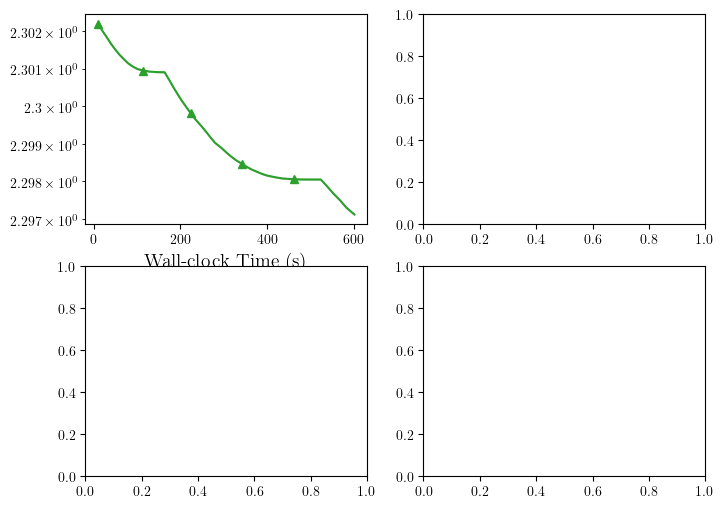

In [20]:
datasets = [#{"dataset": "fashion-mnist", "ylims": (0.8, 0.95)},
            {"dataset": "devnagari-script", "ylims": (0.8, 1.0)},
            {"dataset": "volkert", "ylims": (0.5, 0.7)}]

plot_metric_w_quantiles_multiple_datasets_xaxes(datasets, entity_name, opts, metrics[0], colors, markers, xaxes, save_dir)

Final: sgd fashion-mnist train_acc 0.9099837996065617 1.0
Final: adam fashion-mnist train_acc 0.9999374210834503 1.0
Final: yogi fashion-mnist train_acc 0.999978768825531 1.0
Final: adahessian fashion-mnist train_acc 0.9100000001490116 1.0
Final: shampoo fashion-mnist train_acc 0.9984783172607422 0.9999124586582184
Final: sketchysgd fashion-mnist train_acc 0.999962568283081 1.0
Final: sgd fashion-mnist train_acc 0.9099837996065617 1.0
Final: adam fashion-mnist train_acc 0.9999374210834503 1.0
Final: yogi fashion-mnist train_acc 0.999978768825531 1.0
Final: adahessian fashion-mnist train_acc 0.9100000001490116 1.0
Final: shampoo fashion-mnist train_acc 0.9984783172607422 0.9999124586582184
Final: sketchysgd fashion-mnist train_acc 0.999962568283081 1.0
Final: sgd devnagari-script train_acc 0.021739130839705467 1.0
Final: adam devnagari-script train_acc 0.9999862849712372 1.0
Final: yogi devnagari-script train_acc 0.9999847769737243 1.0
Final: adahessian devnagari-script train_acc 1.0 1.

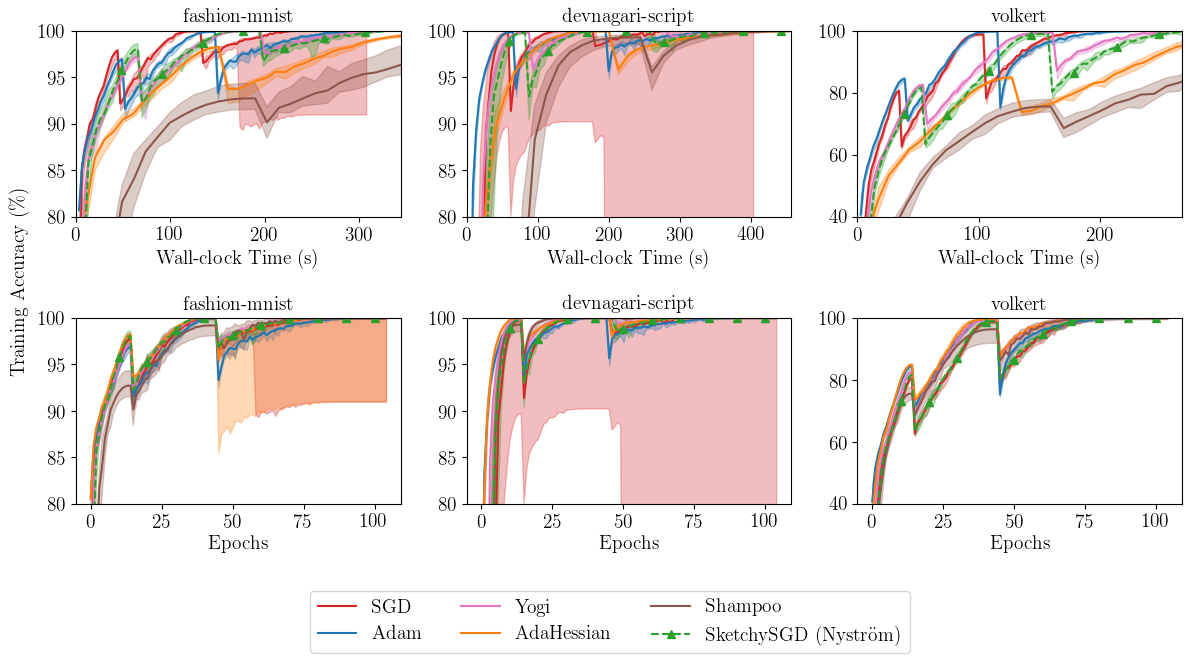

In [81]:
datasets = [{"dataset": "fashion-mnist", "ylims": (0.8, 1.0)},
            {"dataset": "devnagari-script", "ylims": (0.8, 1.0)},
            {"dataset": "volkert", "ylims": (0.4, 1.0)}]

plot_metric_w_quantiles_multiple_datasets_xaxes(datasets, entity_name, opts, metrics[2], colors, markers, xaxes, save_dir)

Final: sgd fashion-mnist test_loss nan nan
Final: adam fashion-mnist test_loss 2.2220509049824306 3.20562460836683
Final: yogi fashion-mnist test_loss 1.0502238379887172 1.1272882098061698
Final: adahessian fashion-mnist test_loss nan nan
Final: shampoo fashion-mnist test_loss 1.0893228574957168 1.4692904850142343
Final: sketchysgd fashion-mnist test_loss 0.9368608852590833 1.004955890737261
Final: sgd fashion-mnist test_loss nan nan
Final: adam fashion-mnist test_loss 2.2220509049824306 3.20562460836683
Final: yogi fashion-mnist test_loss 1.0502238379887172 1.1272882098061698
Final: adahessian fashion-mnist test_loss nan nan
Final: shampoo fashion-mnist test_loss 1.0893228574957168 1.4692904850142343
Final: sketchysgd fashion-mnist test_loss 0.9368608852590833 1.004955890737261
Final: sgd devnagari-script test_loss nan nan
Final: adam devnagari-script test_loss 0.7551658000220424 0.9768913295787314
Final: yogi devnagari-script test_loss 0.3877007483140282 0.4523424625189408
Final: ada

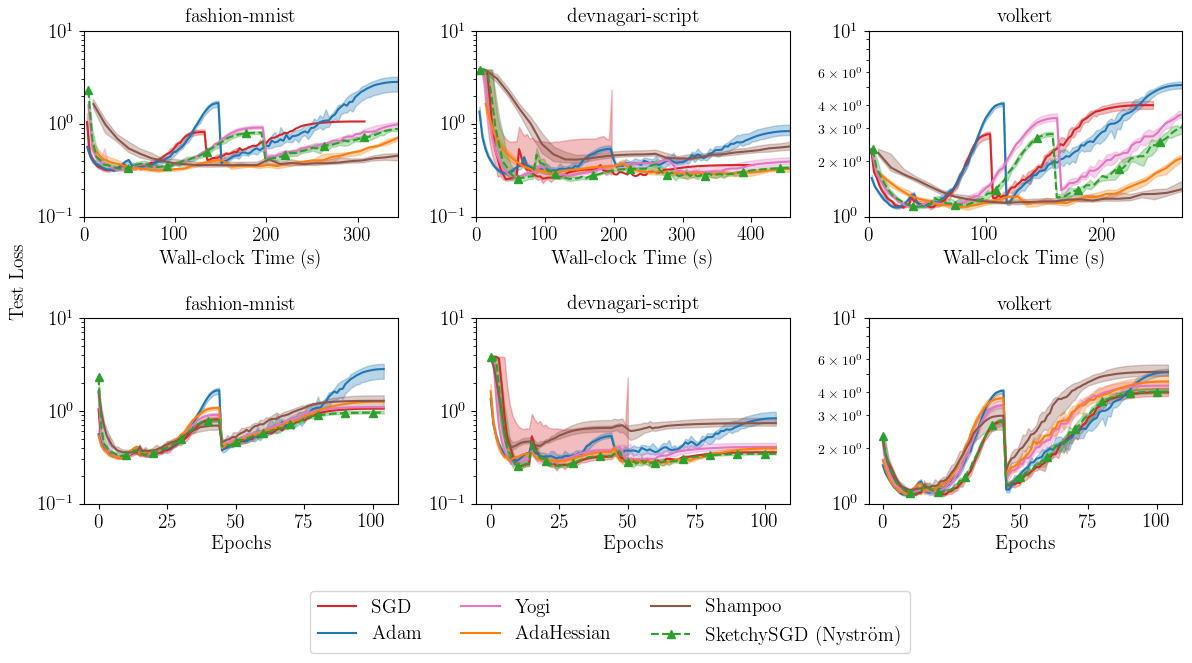

In [82]:
datasets = [{"dataset": "fashion-mnist", "ylims": (1e-1, 1e1)},
            {"dataset": "devnagari-script", "ylims": (1e-1, 1e1)},
            {"dataset": "volkert", "ylims": (1e0, 1e1)}]

plot_metric_w_quantiles_multiple_datasets_xaxes(datasets, entity_name, opts, metrics[1], colors, markers, xaxes, save_dir)

Final: sgd fashion-mnist train_loss nan nan
Final: adam fashion-mnist train_loss 4.68559354817054e-05 0.00016933855802729204
Final: yogi fashion-mnist train_loss 1.963542707723848e-05 8.257650821511295e-05
Final: adahessian fashion-mnist train_loss nan nan
Final: shampoo fashion-mnist train_loss 0.0004510371674667113 0.007108320021735769
Final: sketchysgd fashion-mnist train_loss 2.854913545306772e-05 0.000196628188889008
Final: sgd fashion-mnist train_loss nan nan
Final: adam fashion-mnist train_loss 4.68559354817054e-05 0.00016933855802729204
Final: yogi fashion-mnist train_loss 1.963542707723848e-05 8.257650821511295e-05
Final: adahessian fashion-mnist train_loss nan nan
Final: shampoo fashion-mnist train_loss 0.0004510371674667113 0.007108320021735769
Final: sketchysgd fashion-mnist train_loss 2.854913545306772e-05 0.000196628188889008
Final: sgd devnagari-script train_loss nan nan
Final: adam devnagari-script train_loss 4.9892320057551845e-06 4.723917896658152e-05
Final: yogi devn

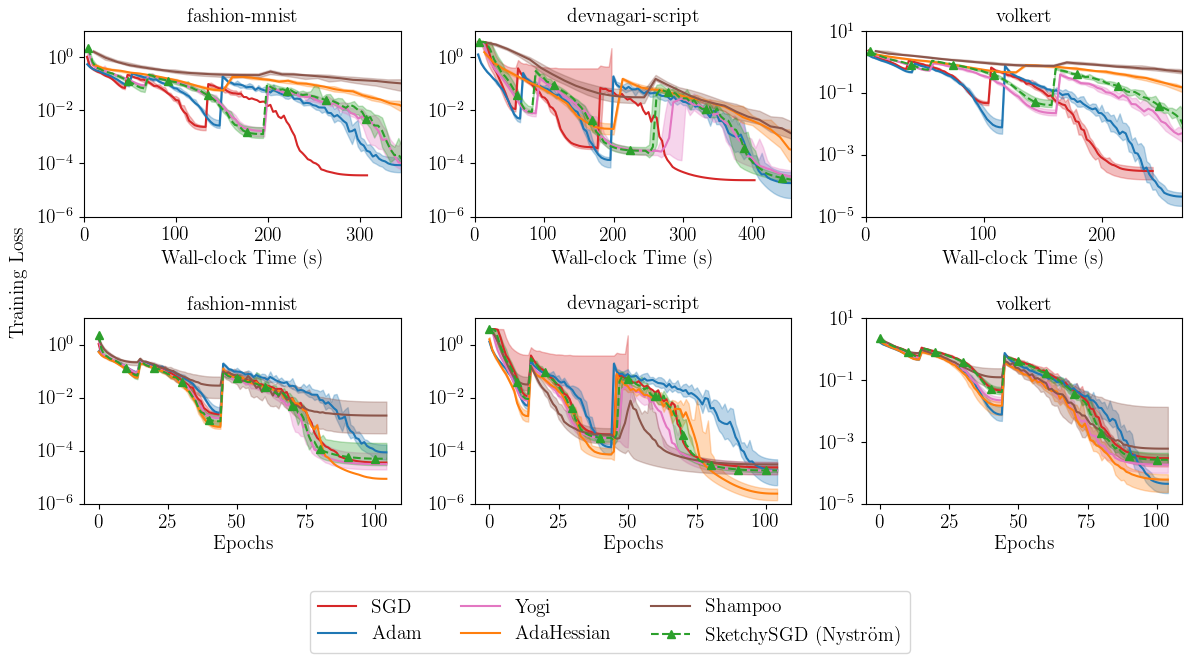

In [83]:
datasets = [{"dataset": "fashion-mnist", "ylims": (1e-6, 1e1)},
            {"dataset": "devnagari-script", "ylims": (1e-6, 1e1)},
            {"dataset": "volkert", "ylims": (1e-5, 1e1)}]

plot_metric_w_quantiles_multiple_datasets_xaxes(datasets, entity_name, opts, metrics[0], colors, markers, xaxes, save_dir)

In [84]:
# datasets = [{"dataset": "fashion-mnist", "ylims": (0.8, 0.95)},
#             {"dataset": "devnagari-script", "ylims": (0.8, 1.0)},
#             {"dataset": "volkert", "ylims": (0.5, 0.7)}]

# plot_metric_w_quantiles_multiple_datasets(datasets, entity_name, opts, metrics[3], colors, markers, xaxes[0], save_dir)
# plot_metric_w_quantiles_multiple_datasets(datasets, entity_name, opts, metrics[3], colors, markers, xaxes[1], save_dir)

In [85]:
# datasets = [{"dataset": "fashion-mnist", "ylims": (0.8, 1.0)},
#             {"dataset": "devnagari-script", "ylims": (0.8, 1.0)},
#             {"dataset": "volkert", "ylims": (0.4, 1.0)}]

# plot_metric_w_quantiles_multiple_datasets(datasets, entity_name, opts, metrics[2], colors, markers, xaxes[0], save_dir)
# plot_metric_w_quantiles_multiple_datasets(datasets, entity_name, opts, metrics[2], colors, markers, xaxes[1], save_dir)

In [86]:
# datasets = [{"dataset": "fashion-mnist", "ylims": (1e-1, 1e1)},
#             {"dataset": "devnagari-script", "ylims": (1e-1, 1e1)},
#             {"dataset": "volkert", "ylims": (1e0, 1e1)}]

# plot_metric_w_quantiles_multiple_datasets(datasets, entity_name, opts, metrics[1], colors, markers, xaxes[0], save_dir)
# plot_metric_w_quantiles_multiple_datasets(datasets, entity_name, opts, metrics[1], colors, markers, xaxes[1], save_dir)

In [87]:
# datasets = [{"dataset": "fashion-mnist", "ylims": (1e-6, 1e1)},
#             {"dataset": "devnagari-script", "ylims": (1e-6, 1e1)},
#             {"dataset": "volkert", "ylims": (1e-5, 1e1)}]

# plot_metric_w_quantiles_multiple_datasets(datasets, entity_name, opts, metrics[0], colors, markers, xaxes[0], save_dir)
# plot_metric_w_quantiles_multiple_datasets(datasets, entity_name, opts, metrics[0], colors, markers, xaxes[1], save_dir)

### fashion-mnist

In [88]:
# dataset = 'fashion-mnist'
# plot_metric_w_quantiles(dataset, entity_name, opts, metrics[3], colors, xaxes[1], (0.8, 1.0), save_dir)
# plot_metric_w_quantiles(dataset, entity_name, opts, metrics[2], colors, xaxes[1], (0.8, 1.0), save_dir)
# plot_metric_w_quantiles(dataset, entity_name, opts, metrics[1], colors, xaxes[1], (1e-1, 1e1), save_dir)
# plot_metric_w_quantiles(dataset, entity_name, opts, metrics[0], colors, xaxes[1], (1e-6, 1e1), save_dir)

### devnagari-script

In [89]:
# dataset = 'devnagari-script'
# plot_metric_w_quantiles(dataset, entity_name, opts, metrics[3], colors, xaxes[1], (0.8, 1.0), save_dir)
# plot_metric_w_quantiles(dataset, entity_name, opts, metrics[2], colors, xaxes[1], (0.8, 1.0), save_dir)
# plot_metric_w_quantiles(dataset, entity_name, opts, metrics[1], colors, xaxes[1], (1e-1, 1e1), save_dir)
# plot_metric_w_quantiles(dataset, entity_name, opts, metrics[0], colors, xaxes[1], (1e-6, 1e1), save_dir)

### volkert

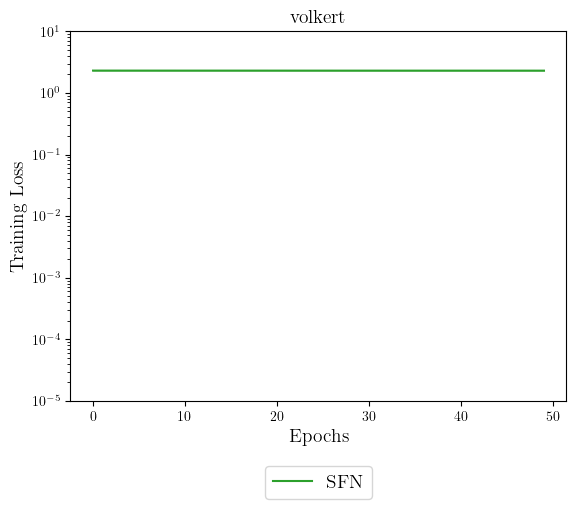

In [9]:
dataset = 'volkert'
# plot_metric_w_quantiles(dataset, entity_name, opts, metrics[3], colors, xaxes[1], (0.5, 0.7), save_dir)
# plot_metric_w_quantiles(dataset, entity_name, opts, metrics[2], colors, xaxes[1], (0.4, 1.0), save_dir)
# plot_metric_w_quantiles(dataset, entity_name, opts, metrics[1], colors, xaxes[1], (1e0, 1e1), save_dir)
plot_metric_w_quantiles(dataset, entity_name, opts, metrics[0], colors, xaxes[1], (1e-5, 1e1), save_dir)

In [11]:
api = wandb.Api()
project_name = f'MLP_SFN_Test'
runs = api.runs(f'{project_name}')

In [28]:
metric = metrics[0]
xaxis = xaxes[0]
opt = opts[0]

In [29]:
metric_trajectories = []
times_trajectories = []
for run in runs:
    if run.state == 'finished':
        metric_trajectories.append(run.history()[metric["name"]])
        times_trajectories.append(run.history()[xaxis["name"]])

In [30]:
metric_trajectories = np.array(metric_trajectories, dtype=float)
median_metric = np.nanmedian(metric_trajectories, axis=0)
median_times = np.nanmedian(times_trajectories, axis=0)

In [31]:
# Compute error bars using np.quantile
alpha=0.20
ci = np.quantile(metric_trajectories, [alpha/2, 1-alpha/2], axis=0)

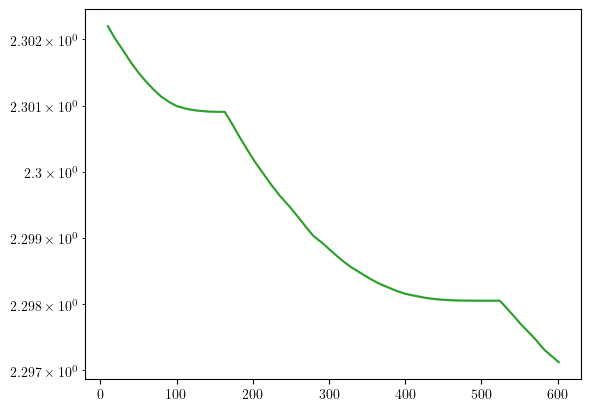

In [32]:
color=colors[opt["name"]]
plt.semilogy(median_times, median_metric, color=color, label=opt["label"])
plt.fill_between(median_times, ci[0], ci[1], color=color, alpha=0.3)

In [15]:
print(runs[0].history().keys())

Index(['time', '_step', 'epoch', '_runtime', 'train_loss', 'test_acc',
       'test_loss', 'train_acc', '_timestamp'],
      dtype='object')
